In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from tqdm.auto import tqdm
import numpy as np

/mnt/ssd-1/gpaulo/miniconda3/envs/default/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

class AttnWrapper(torch.nn.Module):
    def __init__(self, attn):
        super().__init__()
        self.attn = attn
        self.activations = None
        self.add_tensor = None
        self.act_as_identity = False
    #https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L422
    def forward(self, *args, **kwargs):
        if self.act_as_identity:
            kwargs['attention_mask'] += kwargs['attention_mask'][0, 0, 0, 1]*torch.tril(torch.ones(kwargs['attention_mask'].shape,
                                                                                                   dtype=kwargs['attention_mask'].dtype,
                                                                                                   device=kwargs['attention_mask'].device),
                                                                                        diagonal=-1)
        output = self.attn(*args, **kwargs)
        if self.add_tensor is not None:
            output = (output[0] + self.add_tensor,)+output[1:]
        self.activations = output[0]
        return output

    def reset(self):
        self.activations = None
        self.add_tensor = None
        self.act_as_identity = False

class BlockOutputWrapper(torch.nn.Module):
    def __init__(self, block, unembed_matrix, norm):
        super().__init__()
        self.block = block
        self.unembed_matrix = unembed_matrix
        self.norm = norm

        self.block.self_attn = AttnWrapper(self.block.self_attn)
        self.post_attention_layernorm = self.block.post_attention_layernorm

        self.attn_mech_output_unembedded = None
        self.intermediate_res_unembedded = None
        self.mlp_output_unembedded = None
        self.block_output_unembedded = None
        self.add_to_last_tensor = None
        self.output = None

    def forward(self, *args, **kwargs):
        output = self.block(*args, **kwargs)
        if self.add_to_last_tensor is not None:
            #print('performing intervention: add_to_last_tensor')
            output[0][:, -1, :] += self.add_to_last_tensor
        self.output = output[0]
        self.block_output_unembedded = self.unembed_matrix(self.norm(output[0]))
        attn_output = self.block.self_attn.activations
        self.attn_mech_output_unembedded = self.unembed_matrix(self.norm(attn_output))
        attn_output += args[0]
        self.intermediate_res_unembedded = self.unembed_matrix(self.norm(attn_output))
        mlp_output = self.block.mlp(self.post_attention_layernorm(attn_output))
        self.mlp_output_unembedded = self.unembed_matrix(self.norm(mlp_output))
        return output

    def block_add_to_last_tensor(self, tensor):
        self.add_to_last_tensor = tensor

    def attn_add_tensor(self, tensor):
        self.block.self_attn.add_tensor = tensor

    def reset(self):
        self.block.self_attn.reset()
        self.add_to_last_tensor = None

    def get_attn_activations(self):
        return self.block.self_attn.activations

class Llama7BHelper:
    def __init__(self, token, device=None, load_in_8bit=True):
        if device is None:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device
        llama = "meta-llama/Llama-2-7b-hf"
        self.tokenizer = AutoTokenizer.from_pretrained(llama, use_auth_token=token)
        self.model = AutoModelForCausalLM.from_pretrained(llama,device_map={"": "cuda"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
        )
        self.head_unembed = self.model.lm_head
        self.device = next(self.model.parameters()).device
        head = self.head_unembed
        for i, layer in enumerate(self.model.model.layers):
            self.model.model.layers[i] = BlockOutputWrapper(layer, head, self.model.model.norm)

    def generate_text(self, prompt, max_length=100):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        generate_ids = self.model.generate(inputs.input_ids.to(self.device), max_length=max_length)
        return self.tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]


    def generate_intermediate_text(self, layer_idx, prompt, max_length=100, temperature=1.0):
        layer = self.model.model.layers[layer_idx]
        for _ in range(max_length):
            self.get_logits(prompt)
            next_id = self.sample_next_token(layer.block_output_unembedded[:,-1], temperature=temperature)
            prompt = self.tokenizer.decode(self.tokenizer.encode(prompt)[1:]+[next_id])
            if next_id == model.tokenizer.eos_token_id:
                break
        return prompt

    def sample_next_token(self, logits, temperature=1.0):
        assert temperature >= 0, "temp must be geq 0"
        if temperature == 0:
            return self._sample_greedy(logits)
        return self._sample_basic(logits/temperature)

    def _sample_greedy(self, logits):
        return logits.argmax().item()

    def _sample_basic(self, logits):
        return torch.distributions.categorical.Categorical(logits=logits).sample().item()

    def get_logits(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        with torch.no_grad():
          logits = self.model(inputs.input_ids.to(self.device)).logits
          return logits

    def set_add_attn_output(self, layer, add_output):
        self.model.model.layers[layer].attn_add_tensor(add_output)

    def get_attn_activations(self, layer):
        return self.model.model.layers[layer].get_attn_activations()

    def set_add_to_last_tensor(self, layer, tensor,verbose=False):
      if verbose:
        print('setting up intervention: add tensor to last soft token')
      self.model.model.layers[layer].block_add_to_last_tensor(tensor)

    def reset_all(self):
        for layer in self.model.model.layers:
            layer.reset()

    def print_decoded_activations(self, decoded_activations, label):
        softmaxed = torch.nn.functional.softmax(decoded_activations[0][-1], dim=-1)
        values, indices = torch.topk(softmaxed, 10)
        probs_percent = [int(v * 100) for v in values.tolist()]
        tokens = self.tokenizer.batch_decode(indices.unsqueeze(-1))
        print(label, list(zip(indices.detach().cpu().numpy().tolist(), tokens, probs_percent)))

    def logits_all_layers(self, text, return_attn_mech=False, return_intermediate_res=False, return_mlp=False, return_block=True):
        if return_attn_mech or return_intermediate_res or return_mlp:
            raise NotImplemented("not implemented")
        self.get_logits(text)
        tensors = []
        for i, layer in enumerate(self.model.model.layers):
            tensors += [layer.block_output_unembedded.detach().cpu()]
        return torch.cat(tensors, dim=0)

    def decode_all_layers(self, text, topk=10, print_attn_mech=True, print_intermediate_res=True, print_mlp=True, print_block=True):
        print('Prompt:', text)
        self.get_logits(text)
        for i, layer in enumerate(self.model.model.layers):
            print(f'Layer {i}: Decoded intermediate outputs')
            if print_attn_mech:
                self.print_decoded_activations(layer.attn_mech_output_unembedded, 'Attention mechanism')
            if print_intermediate_res:
                self.print_decoded_activations(layer.intermediate_res_unembedded, 'Intermediate residual stream')
            if print_mlp:
                self.print_decoded_activations(layer.mlp_output_unembedded, 'MLP output')
            if print_block:
                self.print_decoded_activations(layer.block_output_unembedded, 'Block output')
                
    def latents_all_layers(self, text, return_attn_mech=False, return_intermediate_res=False, return_mlp=False, return_mlp_post_activation=False, return_block=True, normalized=True):
        if return_attn_mech or return_intermediate_res or return_mlp:
            raise NotImplemented("not implemented")
        self.get_logits(text)
        tensors = []
        if return_block:
            for i, layer in enumerate(self.model.model.layers):
                if normalized:
                    tensors += [layer.output.detach().cpu()]
                else:
                    tensors += [layer.output_normalized.detach().cpu()]
        elif return_mlp_post_activation:
            for i, layer in enumerate(self.model.model.layers):
                tensors += [layer.mlp_post_activation.detach().cpu()]
        return torch.cat(tensors, dim=0)


In [3]:
model = Llama7BHelper("", load_in_8bit=False)
tokenizer = model.tokenizer

/mnt/ssd-1/gpaulo/miniconda3/envs/default/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:720: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.69s/it]


In [4]:
datasets = []
for lang in [ "fr", "de", "zh", "ru"]:
    csv = f"data/langs/{lang}/clean.csv"
    df = pd.read_csv(csv)
    df.rename(columns={"blank_prompt_translation":f"prompt_{lang}","blank_prompt_original":"prompt_en","blank_prompt_translation_masked":f"prompt_blank_{lang}", "word_translation":f"translation_{lang}","word_original":"translation_en"}, inplace=True)
    if "error" in df.columns:
        df.drop(columns=["error"], inplace=True)
    df.drop(columns=["lang"], inplace=True)
    
    df.sort_values("translation_en")
    df.reset_index(drop=True, inplace=True)
    datasets.append(df)
en = pd.read_csv("data/langs/en/clean.csv")
en.rename(columns={"blank_prompt_translation":"prompt_en","word_translation":"translation_en","blank_prompt_translation_masked":"prompt_blank_en"}, inplace=True)
en.drop(columns=["lang","word_original","blank_prompt_original","error"], inplace=True)
datasets.append(en)
#find the intersection of the datasets
common_df = datasets[0]
for df in datasets[1:]:
    common_df = common_df.merge(df, on=["translation_en","prompt_en"], how="inner")
train_df = common_df.sample(frac=0.8)
test_df = common_df.drop(train_df.index)

In [5]:
#generate few prompt examples
steering_db = {lang:[] for lang in ["en","fr","de","zh","ru"]}
test_db = {lang:[]for lang in ["en","fr","de","zh","ru"]}
#add translations to test_tb
for lang in ["en","fr","de","zh","ru"]:
    test_db["translation_"+lang] = []
for i in range(50):
    prompt = train_df.sample(4).reset_index(drop=True)
    test = test_df.sample(4).reset_index(drop=True)
    for lang in ["en","fr","de","zh","ru"]:
        stering_prompt=""
        for p in prompt[f"prompt_{lang}"].tolist():
            stering_prompt+=p
        steering_db[lang].append(stering_prompt)
        cloze_prompt =""
        for p in test[f"prompt_{lang}"].tolist()[:3]:
            cloze_prompt+=p
        question = test[f"prompt_blank_{lang}"].tolist()[3]
        #cut question at the penultimate '"' 
        question = question[:question.rfind('"')]
        #question = question[:question.rfind('"')]
        cloze_prompt+=question#+'"'
        test_db[lang].append(cloze_prompt)
        test_db["translation_"+lang].append(test[f"translation_{lang}"].tolist()[3])
        
    

steering_db=pd.DataFrame(steering_db, columns=["en","fr","de","zh","ru"])
test_db=pd.DataFrame(test_db, columns=["en","fr","de","zh","ru","translation_en","translation_fr","translation_de","translation_zh","translation_ru"])


In [6]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]


lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}

In [7]:
for lang in ["en","fr","de","zh","ru"]:
    test_db[f'token_id_{lang}'] = [None]*test_db.shape[0]
    for idx, (idx_df, row) in tqdm(enumerate(test_db.iterrows())):
            out_token_str = row[f"translation_{lang}"]   
            out_token_id = process_tokens(out_token_str, model.tokenizer, lang)
            test_db.at[idx, f'token_id_{lang}'] = out_token_id

50it [00:05,  9.33it/s]
50it [00:05,  9.50it/s]
50it [00:05,  9.65it/s]
50it [00:01, 31.90it/s]
50it [00:05,  8.95it/s]


In [90]:
test_db

,en,fr,de,zh,ru,translation_en,translation_fr,translation_de,translation_zh,translation_ru,token_id_en,token_id_fr,token_id_de,token_id_zh,token_id_ru
0,"A ""street"" is a public road in a city, town, o...","Une ""rue"" est une voie publique dans une ville...","Eine ""Straße"" ist eine öffentliche Straße in e...","""街""是城市、镇或村庄中的公共道路。答案：""街""。""心""是一个泵血贯穿全身的器官。答案：""心...",Улица - это дорога общего пользования в городе...,lake,lac,See,湖,озеро,"[18170, 24591, 425, 433, 19437, 301, 29880]","[4620, 425, 433, 24011, 301, 29880]","[2823, 922, 2008, 317, 13393, 29903]","[31496, 233]","[614, 29904, 29495, 211]"
1,"A ""delete"" is used to remove text or data. Ans...","Un ""delete"" est utilisé pour supprimer du text...","Ein ""Löschen"" wird verwendet, um Text oder Dat...","""删""用来移除文本或数据。答案：""删""。""阳""是太阳系中心的一颗恒星，为地球提供光和热。答案...","""Удалить"" используется для удаления текста или...",beauty,beauté,Schönheit,美,красота,"[6562, 367, 915, 289, 29890, 15409]","[6562, 367, 289, 29890, 915]","[28565, 1102, 4421, 29903, 2522, 317, 4504]","[30630, 234]","[29951, 1186, 6697, 3360, 211]"
2,"A ""mouth"" is used to eat food and speak. Answe...","La ""bouche"" sert à manger et à parler. Réponse...","Ein ""Mund"" wird zum Essen und Sprechen benutzt...","""口""用来吃食物和说话。答案：""口""。""六""是在五之后的数字。答案：""六""。""千""是在九百九...",Рот используется для приема пищи и речи. Ответ...,spring,ressort,Feder,春,пружина,"[1028, 4278, 29879, 15099, 269, 805, 6709, 7689]","[620, 1253, 29878, 364, 18475, 337, 276, 690]","[383, 8263, 17972, 29943, 5169, 7351]","[31031, 233]","[12781, 21550, 29964, 469, 211]"
3,"An ""office"" is a place where people usually do...","Un ""bureau"" est un endroit où les gens font ha...","Ein ""Büro"" ist ein Ort, an dem Menschen normal...","""局""是人们通常进行工作的地方。答案：""局""。""北""是一个经常与寒冷和极地地区相关的基本方向...","Офис - это место, где люди обычно выполняют св...",delete,supprimer,löschen,删,удалить,"[29881, 5217, 311, 8143, 6144, 7374, 628, 270,...","[1462, 480, 12587, 29879, 2146, 19303, 13159, ...","[29880, 27575, 301]","[31916, 232]","[863, 19871, 29960, 212]"
4,"A ""tribe"" is a social division in a traditiona...","Une ""tribu"" est une division sociale dans une ...","Ein ""Stamm"" ist eine soziale Abteilung in eine...","""族""是传统社会中由家庭或社区通过社会、经济、宗教或血缘关系链接的社会分支。答案：""族""。""...",Племя - это социальное подразделение в традици...,delete,supprimer,löschen,删,удалить,"[29881, 5217, 311, 8143, 6144, 7374, 628, 270,...","[1462, 480, 12587, 29879, 2146, 19303, 13159, ...","[29880, 27575, 301]","[31916, 232]","[863, 19871, 29960, 212]"
5,"The ""sun"" is a star at the center of the Solar...","Le ""soleil"" est une étoile au centre du systèm...","Die ""Sonne"" ist ein Stern im Zentrum des Sonne...","""阳""是太阳系中心的一颗恒星，为地球提供光和热。答案：""阳""。""球""用来进行足球和篮球等运动...","Солнце - звезда в центре Солнечной системы, об...",spring,ressort,Feder,春,пружина,"[1028, 4278, 29879, 15099, 269, 805, 6709, 7689]","[620, 1253, 29878, 364, 18475, 337, 276, 690]","[383, 8263, 17972, 29943, 5169, 7351]","[31031, 233]","[12781, 21550, 29964, 469, 211]"
6,"""The ""north"" is a cardinal direction often ass...","""Le ""nord"" est une direction cardinale souvent...","""Der ""Norden"" ist eine Himmelsrichtung, die of...","""北""是一个经常与寒冷和极地地区相关的基本方向。答案：""北""。""字""是语言中单独的、有意义的...","""Север"" - это кардинальное направление, часто ...",pond,étang,Teich,池,пруд,"[29886, 12509, 1129, 2818, 1112, 772, 282]","[29948, 904, 2852, 1893, 28899]","[29911, 7141, 323, 1920]","[31853, 233]","[12781, 21550, 29964, 469, 211]"
7,"A ""tribe"" is a social division in a traditiona...","Une ""tribu"" est une division sociale dans une ...","Ein ""Stamm"" ist eine soziale Abteilung in eine...","""族""是传统社会中由家庭或社区通过社会、经济、宗教或血缘关系链接的社会分支。答案：""族""。""...",Племя - это социальное подразделение в традици...,word,mot,Wort,字,слово,"[29893, 6365, 1734, 281, 13762, 8879, 1742, 827]","[14817, 286, 4346, 3184, 2730, 29885]","[14962, 29956, 19662, 399, 13824]","[30578, 232]","[29935, 26443, 531, 19945, 15391, 212]"
8,"A ""machine"" is used to perform a specif

In [6]:
activations={lang:[] for lang in ["en","fr","de","zh","ru"] }
pbar = tqdm(steering_db, desc="Generating activations for steering prompts")
for index,row in tqdm(steering_db.iterrows(),total=len(steering_db)):
    activations["en"].append(model.latents_all_layers(row["en"])[:, -1, :])
    activations["fr"].append(model.latents_all_layers(row["fr"])[:, -1, :])
    activations["de"].append(model.latents_all_layers(row["de"])[:, -1, :])
    activations["zh"].append(model.latents_all_layers(row["zh"])[:, -1, :])
    activations["ru"].append(model.latents_all_layers(row["ru"])[:, -1, :])

100%|██████████| 100/100 [01:11<00:00,  1.41it/s]|          | 0/100 [00:00<?, ?it/s]


In [7]:

for lang in ["en","fr","de","zh","ru"]:
    save=torch.stack(activations[lang],dim=0)
    torch.save(save,f"activations_{lang}.pt")

In [8]:
english_tensor = torch.load("activations_en.pt")
french_tensor = torch.load("activations_fr.pt")
german_tensor = torch.load("activations_de.pt")
chinese_tensor = torch.load("activations_zh.pt")
russian_tensor = torch.load("activations_ru.pt")

In [9]:
steering_vecs = chinese_tensor.mean(dim=1)-russian_tensor.mean(dim=1)


In [10]:
verbose = False
#layer_id = 14
source= "zh"
target= "ru"
lam_probs = {}
for lam in [0]:
  probas_correct_all = []
  probas_steered_all = []
  pbar = tqdm(range(32), total=32)
  for layer_id in pbar:
    model.reset_all()
    model.set_add_to_last_tensor(layer_id, lam*steering_vecs[layer_id].cuda())
    probas_correct_lang = []
    probas_steered_lang = []
    psecondbar = tqdm(test_db.iterrows(), total=len(test_db))
    
    for idx,row in psecondbar:
      prompt = row[source]
      correct = row[f"translation_{source}"]
      steered = row[f"translation_{target}"]
      logits = model.get_logits(prompt)
      source_tok_ids = torch.tensor(row[f'token_id_{source}'], dtype=torch.int64)
      target_tok_ids = torch.tensor(row[f'token_id_{target}'], dtype=torch.int64)
      p_source = logits[0, -1].float().softmax(dim=-1)[source_tok_ids].sum()
      p_target = logits[0, -1].float().softmax(dim=-1)[target_tok_ids].sum()
      probas_correct_lang += [p_source]
      probas_steered_lang += [p_target]

    
      if verbose:
        #print('target', target_df['out_token_str'][idx])
        if idx%10==0:
          print(prompt)
          print('Correct', correct)
          print('Steered', steered)
          
          model.print_decoded_activations(logits, "last token")
          print('============================================')
      #if idx > 10:
      #  break
    probas_correct_all += [probas_correct_lang]
    probas_steered_all += [probas_steered_lang]
    #print(f"Lam {lam} Layer {layer_id} Correct: {probas_correct} Steered: {probas_steered}")
  probas_correct_all = torch.tensor(probas_correct_all)
  probas_steered_all = torch.tensor(probas_steered_all)
  lam_probs[lam] = [probas_correct_all,probas_steered_all]


100%|██████████| 32/32 [04:27<00:00,  8.35s/it]


In [64]:
lam_probs.keys()

dict_keys([2])

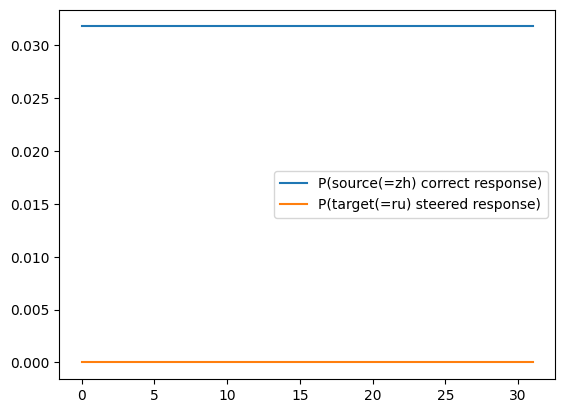

In [12]:
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
plt.plot(lam_probs[0][0].mean(dim=1), label=f'P(source(=zh) correct response)')
plt.plot(lam_probs[0][1].mean(dim=1), label=f'P(target(=ru) steered response)')
plt.legend()
plt.show()


In [13]:
probas_correct_all

tensor([0.0000, 0.0300, 0.0000, 0.0300, 0.0000, 0.0900, 0.0600, 0.0700, 0.0000,
        0.0400, 0.0000, 0.0600, 0.0500, 0.0100, 0.0000, 0.0000, 0.0000, 0.0400,
        0.0000, 0.0200, 0.1000, 0.1300, 0.2400, 0.2100, 0.1900, 0.2300, 0.1800,
        0.1500, 0.2100, 0.1800, 0.2000, 0.2000])